## Importing

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler

import os

from tqdm.auto import tqdm

import shutil

from itertools import groupby

import matplotlib.pyplot as plt

from statistics import mean

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy import signal

import tensorflow as tf
from tensorflow import keras

import pickle

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path of original data folder
data_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data"
# path of csv files, each file is a 2mins walk for a subject
csvD_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/csv_files"
# In this file, the Null values are replaved with 0 in the HY scale - Null values were given to healthy control
demographics = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/Processed_data/demographics_HYprocessed.csv" 
dem_df = pd.read_csv(demographics)
# parequet folder path
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"

## Data

In [233]:
class Data:
  def __init__(self, prepare_or_get, data_folder, demographics_file, parquet_path):
    '''
    :param prepare_or_get:  1: prepare data , 0: load preloaded datas (npy)
    :param data_folder: path for a folder containing csv files, file for each 2 mins walk (for indivdiual subject)
    :param demographics_file: path for csv demographics file
    :save_path: path where to save/read parquet files after preparing them
    :
    '''

    self.data_path = data_folder
    self.parquet_path= parquet_path
    self.dem_path= demographics_file
    self.scale="HoehnYahr"            # fixed for now
    self.seconds_to_discard = 20      # fixed for now
    self.rows_to_discard = 100 * self.seconds_to_discard
    
    # data in arrays
    self.signals_data = []
    self.cycles_data=[]
    self.statical_data=[]
  

    if (prepare_or_get==1):
      self.prepare_data()
    elif (prepare_or_get==0):
      self.get_data()
  
  def get_data(self):
    self.signals_data_df= pd.read_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df=pd.read_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df=pd.read_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df=pd.read_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df=pd.read_parquet(self.parquet_path+'right_stances.gzip')

  def prepare_data(self):
    # loop over files, each file is a 2 min walk for a single individual
    # files are expected to be in csv format
    self.dem_df = pd.read_csv(self.dem_path)
    for name in tqdm((os.listdir(self.data_path))):
       
      # id of subject
      id = name.split('_')[0]

      # disease level according to 'self.scale'
      level = self.get_pd_level( id)

      # parkinon's patient OR healthy control ?
      if 'Co' in name:  
        parkinson = 0 # Healthy control
      elif 'Pt' in name:
        parkinson = 1 # Parkinson's Patient

      # read and filter one file
      one_walk=self.read_filter(name)

      # sum of values from all the left sensors
      one_walk['Total_Force_Left'] = one_walk[list(one_walk.columns[0:8])].sum(axis=1)
     
      # sum of values from all the right sensors
      one_walk['Total_Force_Right'] = one_walk[list(one_walk.columns[8:16])].sum(axis=1)
      
      # convert to lists
      one_walk_lists=[]*18
      for column in one_walk.columns.values.tolist():
        one_walk_lists.append(one_walk[column].tolist()) 

      ## Left foot related ##
      l_stances, l_strides_time , l_swings_time, l_stances_time, l_indices = self.segment_signal(one_walk_lists[16])
      # Find maximum VGRF at heel strike for each gait cycle 
      l_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[0],l_indices) # sensor 0 = left heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      l_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[7],l_indices) # sensor 7 = left toe sensor

      ## right foot related ##
      r_stances, r_strides_time , r_swings_time, r_stances_time, r_indices = self.segment_signal(one_walk_lists[17])
      # Find maximum VGRF at heel strike for each gait cycle 
      r_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[8],l_indices) # sensor 8 = right heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      r_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[15],l_indices) # sensor 15 = right toe sensor


      ## Saving data ##

      # Raw Signals
      self.signals_data.append([id,level,parkinson] +one_walk_lists)

      # Statical
      self.statical_data.append( [ id, level, parkinson 
                                , mean (l_swings_time) , np.std(l_swings_time), (mean (l_swings_time) / np.std(l_swings_time) *100)
                                , mean (l_strides_time) , np.std(l_strides_time) , (mean (l_strides_time) / np.std(l_strides_time)*100)
                                , kurtosis(l_strides_time), skew(l_strides_time)
                                , mean (l_stances_time) , np.std(l_stances_time) , ( mean (l_stances_time) / np.std(l_stances_time) *100) 

                                , mean (r_swings_time) , np.std(r_swings_time), (mean (r_swings_time) / np.std(r_swings_time) *100)
                                , mean (r_strides_time) , np.std(r_strides_time) , (mean (r_strides_time) / np.std(r_strides_time)*100)
                                , kurtosis(r_strides_time), skew(r_strides_time)
                                , mean (r_stances_time) , np.std(r_stances_time) , ( mean (r_stances_time) / np.std(r_stances_time) *100)
                                
                                , mean (l_peaks_heel) , np.std(l_peaks_heel) ,mean (l_peaks_toe) , np.std(l_peaks_toe)
                                , mean (r_peaks_heel) , np.std(r_peaks_heel) ,mean (r_peaks_toe) , np.std(r_peaks_toe)
                                  ] )
      
      
      # Segmented Signals
      
      # NEED TO BE MOVED TO SEPERATE FUNCTION
      # only for segmented data, for a trial we need each stance phase with the following 
      # swing phases's time, so here we are adjusting the phases to be equal

      dif_l =  len(l_stances)-len(l_swings_time)
      if (dif_l > 0):
        l_stances=l_stances[:-dif_l]
      elif(dif_l < 0):
        l_swings_time= l_swings_time[:dif_l]
      
      #print([len(r_peaks_toe), len(r_peaks_heel),len(r_strides_time),len(r_swings_time),len(r_stances)])
      
      min_r = min([len(r_peaks_toe), len(r_peaks_heel),len(r_strides_time),len(r_swings_time),len(r_stances)])
      if (min_r -len(r_stances) !=0): r_stances=r_stances[:(min_r -len(r_stances) )]
      if (min_r -len(r_swings_time) !=0): r_swings_time = r_swings_time[:(min_r -len(r_swings_time) )]
      if (min_r -len(r_peaks_toe) !=0): r_peaks_toe = r_peaks_toe[:(min_r -len(r_peaks_toe) )]
      if (min_r -len(r_peaks_heel) !=0): r_peaks_heel = r_peaks_heel[:(min_r -len(r_peaks_heel) )]
      if (min_r -len(r_strides_time) !=0): r_strides_time = r_strides_time[:(min_r -len(r_strides_time) )]
      
      #print([len(r_peaks_toe), len(r_peaks_heel),len(r_strides_time),len(r_swings_time),len(r_stances)])
      '''
      dif_r =  len(r_stances)-len(r_swings_time)
      if (dif_r>0):
        r_stances=r_stances[:-dif_r]
      elif(dif_r < 0):
        r_swings_time = r_swings_time[:dif_r]
       

      '''
      self.cycles_data.append( [ id, level, parkinson ] 
                        + [l_stances] + [l_strides_time] + [l_swings_time] + [l_stances_time]
                        + [r_stances] + [r_strides_time] + [r_swings_time] + [r_stances_time]
                        + [l_peaks_heel] + [l_peaks_toe]
                        + [r_peaks_heel] + [r_peaks_toe]
                        )

    self.statical_data_to_df()
    self.cycles_data_to_df()
    self.signal_data_to_df()
    ## Get individual stances data frames
    self.ind_stances_to_df()
    ## writing files ##
    self.save_files()

  def get_pd_level(self, subject_id):
    level = self.dem_df[self.scale][dem_df['ID'] == subject_id ].values[0]
    return level

  def read_filter(self,name):
      # Reading each file, skipping 3 columns (time,total right forces & total left forces)
      # For gait cycle segmentation, to eliminate the effect of gait initiation and termenation,
      # the first and last N=20 seconds of VGRF data was discarded.

      one_walk = pd.read_csv(self.data_path + '/' + name,
                             skiprows=list(range(1,self.rows_to_discard+1)) ,
                             skipfooter=self.rows_to_discard,
                             usecols = np.arange(1,17),
                             engine = 'python')  
      
      # Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
      one_walk.where(one_walk > 20, 0, inplace=True)

      return one_walk

  def segment_signal(self, signal):
      # swing - stance phases repeatly
      phases = [list(g) for k, g in groupby((signal), lambda x:x>0)]
      
      # Deleting the first and last phase, since the first and last 20 seconds were deleted,
      # there's no garanty that the first and last phase are complete
      # Hence, they are being deleted here just for safety

      phases = phases[1:-1]

      # filtering phases that is shorter than 20 becuase must propably it's noise
      phases = [l for l in phases if len(l)>20]

      # indices of the gait cycles
      indices=[0]
      for i in range(1, len(phases),2):
        indices.append(indices[-1]+len(phases[i]) + len(phases[i-1]))

      # stances phases
      stances = [l for l in phases if any(l)]
      
      # strides times 
      strides_time =  [((len(phases[i]) + len(phases[i-1]) -1)*0.01 ) for i in range(1,len(phases),2)]

      # swings time
      swings_time = [(len(l)-1)*0.01 for l in phases if not all (l)]

      # stance time 
      stances_time = [(len(l)-1)*0.01 for l in stances]

      return stances, strides_time , swings_time, stances_time, indices

  def get_max_per_gait_cycle(self, signal,indices):
    gait_cycles = self.get_gait_cycles(signal, indices)
    peaks = [max(cycle) for cycle in gait_cycles]
    return peaks

  def get_gait_cycles(self, signal, indices):
    # get gait cycles
    gait_cycles= [signal[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    return gait_cycles

  def signal_data_to_df(self):
    self.signals_data_df = pd.DataFrame(self.signals_data, columns =["ID", "level", "y", "L1", "L2","L3", "L4","L5","L6","L7","L8",
                                       "R1", "R2","R3", "R4","R5","R6","R7","R8","Total_Force_Right","Total_Force_Left" ])
     
    
  def cycles_data_to_df(self):
    self.cycles_data_df = pd.DataFrame(self.cycles_data, columns =["ID", "level", "y", 
                                                                   "l_stances", "l_strides_time", "l_swings_time" , "l_stances_time"
                                                                  , "r_stances" , "r_strides_time" , "r_swings_time" , "r_stances_time"
                                                                  , "l_peaks_heel" , "l_peaks_toe"
                                                                  , "r_peaks_heel" , "r_peaks_toe" ])
    

  def statical_data_to_df(self):
    self.statical_data_df = pd.DataFrame(self.statical_data, columns =["ID", "level", "y"
                                                                      , "mean_left_swings_time" , "std_left_swings_time", "cv_left_swings_time"
                                                                      , "mean_left_stride_time" , "std_left_stride_time" ,"cv_left_stride_time"
                                                                      , "kurtosis_left_strides_time", "skew_left_strides_time"
                                                                      , "mean_left_stance_time" , "std_left_stance_time", "cv_left_stance_time"
                                                                      , "mean_right_swings_time" , "std_right_swings_time", "cv_right_swings_time"
                                                                      , "mean_right_stride_time" , "std_right_stride_time", "cv_right_stride_time"
                                                                      , "kurtosis_right_strides_time", "skew_right_strides_time"
                                                                      , "mean_right_stance_time" , "std_right_stance_time", "cv_right_stance_time"
                                                                      , "mean_left_peaks_heel" , "std_left_peaks_heel"
                                                                      , "mean_left_peaks_toe" , "std_left_peaks_toe"
                                                                      , "mean_right_peaks_heel" , "std_right_peaks_heel"
                                                                      , "mean_right_peaks_toe" , "std_right_peaks_toe"
                                                                       ])
  def ind_stances_to_df(self):
    #droping NNOT WORKING HERE
    self.left_stances_df = self.cycles_data_df.explode(["l_stances","l_swings_time"])
    self.left_stances_df = self.left_stances_df.drop(columns=["r_stances" ,	"r_strides_time" ,	"r_swings_time" ,	"r_stances_time", "r_peaks_heel" ,	"r_peaks_toe"], axis=1)

    self.right_stances_df = self.cycles_data_df.explode(["r_stances","r_swings_time","r_peaks_toe","r_peaks_heel","r_strides_time"]) 
    self.right_stances_df = self.right_stances_df.drop(columns=["l_stances" ,	"l_strides_time" ,	"l_swings_time" ,	"l_stances_time", "l_peaks_heel" ,	"l_peaks_toe"], axis=1)

  def save_files(self):
    self.signals_data_df.to_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df.to_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df.to_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df.to_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df.to_parquet(self.parquet_path+'right_stances.gzip')

In [234]:
# Prepare the data
# data = Data( 1, csvD_path, demographics,parquet_path)

  0%|          | 0/304 [00:00<?, ?it/s]

In [194]:
# read prepare data
data = Data( 0, "", "",parquet_path)

In [239]:
### SHOULD be applied for all dataframes after `explode`
data.right_stances_df = data.right_stances_df.reset_index(drop=True)

In [11]:
data.right_stances_df['max_peak'] = data.right_stances_df['r_stances'].apply(lambda x: max(x))

## FWHM 

the scaling should be as folloowing
find the points X_left and X_right you can scale the actual data. I.e. x1 = (x-X_left)/(X_right-X_left), y1= y/Y_max. After that you can select a fixed x range e.g. np.linspace(-0.5,1.5,100) and get interpolated scaled shape for each siganl

In this code, we first calculate the FWHM.
We then scale the signal by dividing the x values by the FWHM and dividing the y values by the maximum y value. 
We also interpolate the scaled signal onto a fixed x range using np.interp. Finally, we plot the original and scaled signals, as well as the interpolated scaled signal. 
The result should show that the peak is now narrower and taller in the scaled signal, and that the interpolated scaled signal has the same shape as the original signal.

### Function for calculating & scaling by FWHM

In [102]:
def fwhm(y,l_inter_x, r_inter_x):
  # Find the peak location
  x= np.linspace (0,len(y)*0.01,len(y))
  peak_idx = np.argmax(y)
  peak_pos = x[peak_idx]

  # Calculate the FWHM
  half_max = y[peak_idx] / 2
  left_idx = np.argmin(np.abs(y[:peak_idx] - half_max))
  right_idx = np.argmin(np.abs(y[peak_idx:] - half_max)) + peak_idx
  fwhm = x[right_idx] - x[left_idx]

  # Scale the signal by the FWHM
  scaled_x = (x - x[left_idx]) / fwhm
  scaled_y = y / np.max(y)

  # Interpolate the scaled signal onto a fixed x range
  new_x = np.linspace(l_inter_x, r_inter_x, 100)
  new_y = np.interp(new_x, scaled_x, scaled_y)

  return [fwhm,max(y),scaled_x,scaled_y,new_x,new_y,peak_pos]

### Function for plotting the results

In [54]:
def plot_signals(x, y,scaled_x, scaled_y,new_x, new_y,peak_pos):
  # Plot the original and scaled signals
  plt.plot(x, y, label='Original')
  plt.plot(scaled_x, scaled_y, label='Scaled')
  plt.plot(new_x, new_y, label='Interpolated')
  plt.axvline(peak_pos, color='r', linestyle='--', label='Peak Position')
  plt.legend()
  plt.show()

### Generating a sample signal with a Gaussian-shaped peak and applying FWHM

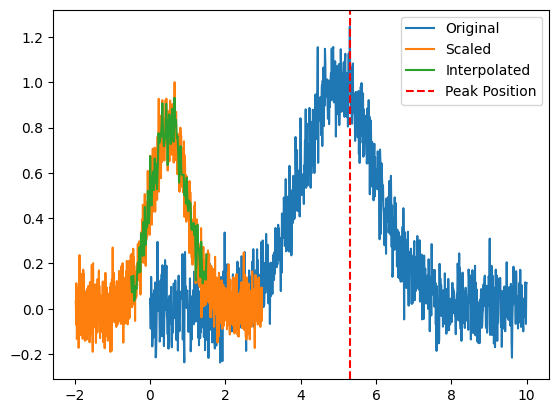

In [242]:
##### EXAMPLE ######
# Generate a sample signal with a peak
x= np.linspace (0,1000*0.01,1000)
y = np.exp(-(x - 5)**2 / 2) + np.random.normal(0, 0.1, size=1000)

fwhm_value, max_peak,scaled_x, scaled_y, new_x ,new_y,peak_pos = fwhm ( y, -0.5,1.5)
plot_signals(x, y,scaled_x, scaled_y,new_x, new_y,peak_pos)

### Exaple from data

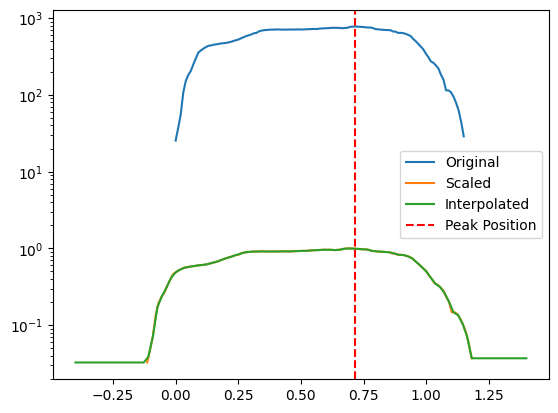

In [109]:
### Example from Data ###
y =  data.right_stances_df['r_stances'][4]  
x = np.linspace (0,len(y)*0.01,len(y))
fwhm_value, max_peak,scaled_x, scaled_y, new_x ,new_y,peak_pos = fwhm ( y, -0.4,1.4)

## Plot with log scale
plt.plot(x, y, label='Original')
plt.plot(scaled_x, scaled_y, label='Scaled')
plt.plot(new_x, new_y, label='Interpolated')
plt.yscale('log')
plt.axvline(peak_pos, color='r', linestyle='--', label='Peak Position')
plt.legend()
plt.show()

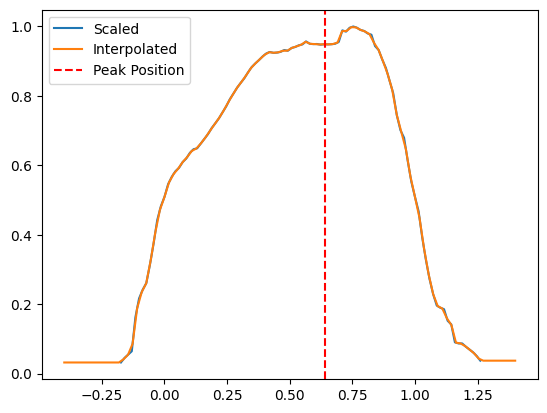

In [58]:
# Interpolate the scaled signal onto a fixed x range
plt.plot(scaled_x, scaled_y, label='Scaled')
plt.plot(new_x, new_y, label='Interpolated')
plt.axvline(peak_pos, color='r', linestyle='--', label='Peak Position')
plt.legend()
plt.show()

### Applying the scaling on the stances from the dataset

In [105]:
tqdm.pandas()

In [159]:
s=data.right_stances_df['r_stances'].progress_map(lambda x: fwhm(x, -0.4,1.4))

  0%|          | 0/18387 [00:00<?, ?it/s]

In [167]:
data.right_stances_df[['fwhm_value','max_peak' ,'scaled_x', 'scaled_y', 'new_x' ,'new_y','peak_pos']] = pd.DataFrame(s.tolist(), index= data.right_stances_df.index)

In [168]:
data.right_stances_df.head()

,ID,level,y,r_stances,r_strides_time,r_swings_time,r_stances_time,r_peaks_heel,r_peaks_toe,max_peak,fwhm_value,scaled_x,scaled_y,new_x,new_y,peak_pos
0,GaPt03,3.0,1,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.39,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",731.61,0.927731,"[-0.13043478260869568, -0.11956521739130437, -...","[0.02841677943166442, 0.03788903924221922, 0.0...","[-0.4, -0.38181818181818183, -0.36363636363636...","[0.02841677943166442, 0.02841677943166442, 0.0...",0.443697
1,GaPt03,3.0,1,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.21,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",774.73,0.747048,"[-0.14864864864864863, -0.13513513513513511, -...","[0.06815277580576458, 0.08930853329547067, 0.0...","[-0.4, -0.38181818181818183, -0.36363636363636...","[0.06815277580576458, 0.06815277580576458, 0.0...",0.545143
2,GaPt03,3.0,1,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",717.75,0.696970,"[-0.17391304347826086, -0.15942028985507248, -...","[0.03218390804597701, 0.04521072796934866, 0.0...","[-0.4, -0.38181818181818183, -0.36363636363636...","[0.03218390804597701, 0.03218390804597701, 0.0...",0.646465
3,GaPt03,3.0,1,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.43,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",742.50,0.757143,"[-0.16000000000000003, -0.1466666666666667, -0...","[0.031111111111111117, 0.056148148148148155, 0...","[-0.4, -0.38181818181818183, -0.36363636363636...","[0.031111111111111117, 0.031111111111111117, 0...",0.656190
4,GaPt03,3.0,1,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",779.79,0.887719,"[-0.11363636363636363, -0.10227272727272727, -...","[0.032585696148963186, 0.0475384398363662, 0.0...","[-0.4, -0.38181818181818183, -0.36363636363636...","[0.032585696148963186, 0.032585696148963186, 0...",0.716228


### train-test data

In [169]:
df1 = data.right_stances_df[[ 'new_y','r_swings_time','max_peak','fwhm_value']]
y = data.right_stances_df[[ 'y']]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(df1, y, random_state=42)

### Reshape the data to be fit in the model (RF)

#### Train

In [179]:
scaled_train_data = np.append( np.asarray(X_train['new_y'].tolist()) , np.asarray(X_train[["r_swings_time" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["max_peak" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["fwhm_value" ]]),  axis=1)

#### Test


In [177]:
scaled_test_data = np.append( np.asarray(X_test['new_y'].tolist()) , np.asarray(X_test[["r_swings_time" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["max_peak" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["fwhm_value" ]]),  axis=1)

### Reshape the data for Hybrid model

#### train data

In [185]:
X_train['new_y'] = X_train['new_y'].apply(np.array)

In [186]:
x = X_train[['new_y', 'r_swings_time','max_peak','fwhm_value']]

In [187]:
itemized_train_data = x.to_numpy()

#### Test data

In [188]:
X_test['new_y'] = X_test['new_y'].apply(np.array)

In [190]:
x_test = X_test[['new_y', 'r_swings_time','max_peak','fwhm_value']]

In [191]:
itemized_test_data = x_test.to_numpy()

## Random Forest with 200 estimators

In [183]:
# Train a Random Forest classifier on the training set
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(scaled_train_data, y_train.values.ravel())

RandomForestClassifier(n_estimators=200, random_state=42)

In [184]:
# Evaluate the performance of the classifier on the testing set
y_pred = rf_classifier.predict(scaled_test_data)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9188601261692408


## Add data features

We have r_strides_time, r_peaks_toe, r_peaks_heel as extra features

In [237]:
data.right_stances_df.head()

,ID,level,y,r_stances,r_strides_time,r_swings_time,r_stances_time,r_peaks_heel,r_peaks_toe
0,GaPt03,3.0,1,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13...",1.59,0.39,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...",107.8,80.63
0,GaPt03,3.0,1,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1...",1.27,0.21,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...",71.17,134.42
0,GaPt03,3.0,1,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17...",1.41,0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...",111.1,80.63
0,GaPt03,3.0,1,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2...",1.49,0.43,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...",141.24,71.61
0,GaPt03,3.0,1,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ...",1.56,0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...",101.2,98.78


In [243]:
data.right_stances_df['r_stances'] = data.right_stances_df['r_stances'].apply(np.array)

In [244]:
### SCALING
tqdm.pandas()
s=data.right_stances_df['r_stances'].progress_map(lambda x: fwhm(x, -0.4,1.4))

  0%|          | 0/18290 [00:00<?, ?it/s]

In [245]:
data.right_stances_df[['fwhm_value','max_peak' ,'scaled_x', 'scaled_y', 'new_x' ,'new_y','peak_pos']] = pd.DataFrame(s.tolist(), index= data.right_stances_df.index)

In [247]:
### Train - Test data
df1 = data.right_stances_df[[ 'new_y','r_swings_time','max_peak','fwhm_value', 'r_strides_time', 'r_peaks_toe', 'r_peaks_heel' ]]
y = data.right_stances_df[[ 'y']]
X_train, X_test, y_train, y_test = train_test_split(df1, y, random_state=42)

In [248]:
### Reformat data
scaled_train_data = np.append( np.asarray(X_train['new_y'].tolist()) , np.asarray(X_train[["r_swings_time" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["max_peak" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["fwhm_value" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["r_strides_time" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["r_peaks_toe" ]]),  axis=1)
scaled_train_data = np.append( scaled_train_data , np.asarray(X_train[["r_peaks_heel" ]]),  axis=1)

scaled_test_data = np.append( np.asarray(X_test['new_y'].tolist()) , np.asarray(X_test[["r_swings_time" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["max_peak" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["fwhm_value" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["r_strides_time" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["r_peaks_toe" ]]),  axis=1)
scaled_test_data = np.append( scaled_test_data , np.asarray(X_test[["r_peaks_heel" ]]),  axis=1)

### Random forest classifier 1

In [270]:
# Train a Random Forest classifier on the training set
rf_classifier = RandomForestClassifier(n_estimators=200,  n_jobs=2)
rf_classifier.fit(scaled_train_data, y_train.values.ravel())

RandomForestClassifier(n_estimators=200, n_jobs=2)

In [271]:
# Evaluate the performance of the classifier on the testing set
y_pred = rf_classifier.predict(scaled_test_data)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9448939427071944


In [272]:
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [273]:
print("Precision: {}".format(prec))
print("Recall: {}".format(rec))
print("F1: {}".format(f1))

Precision: 0.9356300997280145
Recall: 0.9875598086124402
F1: 0.9608938547486033


In [274]:
# save the model
with open("/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/rf_classifier_7_features", 'wb') as f:
    pickle.dump(rf_classifier, f)

In [275]:
# Load the model                                                                                                                                                                                                       

with open("/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/rf_classifier_7_features", 'rb') as f:
    rf = pickle.load(f)

### Random Forest Classifier 2

In [259]:
# Train a Random Forest classifier on the training set
rf_classifier = RandomForestClassifier(n_estimators=600, random_state=42)
rf_classifier.fit(scaled_train_data, y_train.values.ravel())

RandomForestClassifier(n_estimators=600, random_state=42)

In [260]:
# Evaluate the performance of the classifier on the testing set
y_pred = rf_classifier.predict(scaled_test_data)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9444565930461404


In [261]:
rf_classifier.score(scaled_test_data, np.ravel(y_test))

0.9444565930461404

In [253]:
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [254]:
print("Precision: {}".format(prec))
print("Recall: {}".format(rec))
print("F1: {}".format(f1))

Precision: 0.9363829142684035
Recall: 0.9859649122807017
F1: 0.9605344934742076


### Random classifier multiple

In [262]:
test_score_RFC=[]

for n in [5, 10, 20, 40, 100, 200]:
    clf = RandomForestClassifier(n_estimators = int(n), n_jobs=2)
    clf.fit(scaled_train_data, np.ravel(y_train))
    acc = clf.score(scaled_test_data, np.ravel(y_test))
    test_score_RFC.append(acc)  

In [263]:
for neighbor, tr_sc in zip(([5, 10, 20, 40, 100, 200]),test_score_RFC): 
    print(f"Estimator = {neighbor}")
    print('Accuracy of Random Forest Classifier on test set: {:.2f}'.format(tr_sc))

Estimator = 5
Accuracy of Random Forest Classifier on test set: 0.90
Estimator = 10
Accuracy of Random Forest Classifier on test set: 0.92
Estimator = 20
Accuracy of Random Forest Classifier on test set: 0.93
Estimator = 40
Accuracy of Random Forest Classifier on test set: 0.94
Estimator = 100
Accuracy of Random Forest Classifier on test set: 0.94
Estimator = 200
Accuracy of Random Forest Classifier on test set: 0.94


In [265]:
prediction_clf = clf.predict(scaled_test_data)
prec = precision_score(y_test, prediction_clf)
rec = recall_score(y_test, prediction_clf)
f1 = f1_score(y_test, prediction_clf)
print("Precision: {}".format(prec))
print("Recall: {}".format(rec))
print("F1: {}".format(f1))

Precision: 0.935591170244935
Recall: 0.9869218500797449
F1: 0.9605712511642347
